Stephanie Shaw, xyt-2, 2344808735

In [1]:
import tensorflow as tf
import keras
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

2024-05-06 15:40:37.716584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pip list

Package                      Version
---------------------------- --------
absl-py                      2.1.0
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.3
certifi                      2024.2.2
charset-normalizer           3.3.2
comm                         0.2.2
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.6.7
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.51.0
gast                         0.4.0
google-auth                  2.29.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.62.2
h5py                         3.11.0
idna                         3.7
importlib_metadata           7.1.0
importlib_resources          6.4.0
ipykernel                    6.29.3
ipytho

In [3]:
# tf.get_logger().setLevel('ERROR')

In [4]:
train_data = pd.DataFrame(columns=['text','label'])
test_data = pd.DataFrame(columns=['text','label'])
unique_word = set()

In [5]:
def label_files(directory, label):
    for filename in os.listdir(directory):

        file_index = int(filename[2:filename.find("_")]) 

        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            text = file.read().lower()
            text = re.sub(r'\d+', '', text)  # Remove numbers
            text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
            new_row = {'text':text, 'label':label}
            unique_word.update(text.split())
            
            if 0 <= file_index <= 699:
                train_data.loc[len(train_data)]=new_row
            elif 700 <= file_index <= 999:
                test_data.loc[len(test_data)]=new_row

In [6]:
label_files("../Data/pos",1)
label_files("../Data/neg",0)

In [7]:
print(len(train_data))
print(len(test_data))

1400
600


In [8]:
length = pd.Series()
length = pd.concat([train_data['text'].str.split().str.len(), test_data['text'].str.split().str.len()],ignore_index=True)
average = length.mean()
std = length.std()

In [9]:
print(f"Number of unique words: {len (unique_word) }")
print (f"Average review length: {average:.2f} words")
print(f"Standard deviation of review lengths: {std:.2f} words")

Number of unique words: 47037
Average review length: 644.36 words
Standard deviation of review lengths: 285.05 words


(array([ 75., 537., 743., 417., 136.,  53.,  23.,  13.,   0.,   3.]),
 array([  16. ,  250.7,  485.4,  720.1,  954.8, 1189.5, 1424.2, 1658.9,
        1893.6, 2128.3, 2363. ]),
 <BarContainer object of 10 artists>)

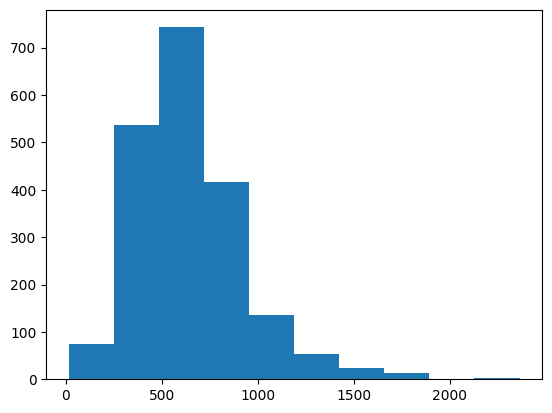

In [10]:
plt.hist(length)

In [11]:
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']
y_test = test_data['label']

In [12]:
t = Tokenizer()
t.fit_on_texts(X_train)
print(t.word_index)

{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'that': 8, 'it': 9, 'as': 10, 'with': 11, 'for': 12, 'his': 13, 'this': 14, 'film': 15, 'but': 16, 'he': 17, 'i': 18, 'on': 19, 'are': 20, 'by': 21, 'its': 22, 'be': 23, 'an': 24, 'one': 25, 'not': 26, 'who': 27, 'movie': 28, 'at': 29, 'was': 30, 'from': 31, 'have': 32, 'has': 33, 'you': 34, 'her': 35, 'they': 36, 'all': 37, 'like': 38, 'so': 39, 'out': 40, 'about': 41, 'more': 42, 'when': 43, 'which': 44, 'up': 45, 'or': 46, 'what': 47, 'their': 48, 'some': 49, 'just': 50, 'if': 51, 'there': 52, 'into': 53, 'him': 54, 'she': 55, 'even': 56, 'only': 57, 'no': 58, 'than': 59, 'good': 60, 'we': 61, 'time': 62, 'most': 63, 'can': 64, 'will': 65, 'films': 66, 'story': 67, 'been': 68, 'would': 69, 'much': 70, 'also': 71, 'get': 72, 'characters': 73, 'other': 74, 'do': 75, 'character': 76, 'very': 77, 'them': 78, 'first': 79, 'two': 80, 'see': 81, 'after': 82, 'well': 83, 'way': 84, 'because': 85, 'does': 86, 'really': 87, 'mak

In [13]:
L = int(length.quantile(.7))
X_train_seq = t.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=L, padding='post', truncating ='post')
X_train_padded[X_train_padded > 5000] = 0

X_test_seq = t.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=L, padding='post', truncating = 'post')
X_test_padded[X_test_padded > 5000] = 0

# [len(sub) for sub in X_train_padded]

## c. Word Embedding

In [14]:
MLP_model = Sequential([Embedding(5001, output_dim=32, input_length=L),
                   Flatten()]) 

## d.MLP

In [15]:
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add(Dropout(0.2))
MLP_model.add(Dense(50, activation='relu')) 
MLP_model.add(Dropout(0.5))
MLP_model.add(Dense(50, activation='relu'))
MLP_model.add (Dropout(0.5))
MLP_model.add(Dense(1, activation='sigmoid'))

In [16]:
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 737, 32)           160032    
                                                                 
 flatten (Flatten)           (None, 23584)             0         
                                                                 
 dense (Dense)               (None, 50)                1179250   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2

In [17]:
MLP_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = MLP_model.fit(X_train_padded, y_train, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 1s 5ms/step - loss: 0.6986 - accuracy: 0.5114
Epoch 2/2
140/140 [==============================] - 1s 5ms/step - loss: 0.6087 - accuracy: 0.6629


In [18]:
train_loss, train_accuracy = MLP_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = MLP_model.evaluate(X_test_padded, y_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.6250


In [19]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.266
Evaluated Train Accuracy: 0.934
Evaluated Test Loss: 0.644
Evaluated Test Accuracy: 0.625


## e. 1D CNN

In [20]:
CNN_model =  Sequential([
    Embedding(input_dim=5001, output_dim=32, input_length=L),  
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),                                            
    Dense(50, activation='relu'),
    Dropout(0.5),                                          
    Dense(1, activation='sigmoid')
])

In [21]:
CNN_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history2 = CNN_model.fit(X_train_padded, y_train, epochs=2, batch_size=10)

Epoch 1/2
140/140 [==============================] - 1s 5ms/step - loss: 0.6962 - accuracy: 0.4929
Epoch 2/2
140/140 [==============================] - 1s 6ms/step - loss: 0.6921 - accuracy: 0.5243


In [22]:
train_loss, train_accuracy = CNN_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = CNN_model.evaluate(X_test_padded, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5017


In [23]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.672
Evaluated Train Accuracy: 0.664
Evaluated Test Loss: 0.692
Evaluated Test Accuracy: 0.502


## f. LSTM RNN

In [24]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
LSTM_model = Sequential([
    Embedding(input_dim=5001, output_dim=32,input_length=L),
    tf.keras.layers.LSTM(32),
    Dropout(0.2),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')
])

2024-05-06 15:40:49.551929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 15:40:49.552749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 15:40:49.553861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [25]:
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 737, 32)           160032    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 177,057
Trainable params: 177,057
Non-tr

In [26]:
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
LSTM_model.fit(X_train_padded, y_train, epochs=10, batch_size=10)

Epoch 1/10


2024-05-06 15:40:49.774795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 15:40:49.776241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 15:40:49.777314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

140/140 [==============================] - 15s 98ms/step - loss: 0.6918 - accuracy: 0.5243
Epoch 2/10
140/140 [==============================] - 14s 100ms/step - loss: 0.6712 - accuracy: 0.5743
Epoch 3/10
140/140 [==============================] - 14s 103ms/step - loss: 0.5934 - accuracy: 0.6493
Epoch 4/10
140/140 [==============================] - 14s 100ms/step - loss: 0.5287 - accuracy: 0.6671
Epoch 5/10
140/140 [==============================] - 14s 101ms/step - loss: 0.4910 - accuracy: 0.6729
Epoch 6/10
140/140 [==============================] - 14s 101ms/step - loss: 0.4829 - accuracy: 0.6736
Epoch 7/10
140/140 [==============================] - 14s 97ms/step - loss: 0.5011 - accuracy: 0.6779
Epoch 8/10
140/140 [==============================] - 14s 97ms/step - loss: 0.4813 - accuracy: 0.6850
Epoch 9/10
140/140 [==============================] - 14s 97ms/step - loss: 0.4801 - accuracy: 0.6864
Epoch 10/10
140/140 [==============================] - 14s 97ms/step - loss: 0.4786 - ac

In [28]:
train_loss, train_accuracy = LSTM_model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = LSTM_model.evaluate(X_test_padded, y_test)

2024-05-06 15:43:09.513732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 15:43:09.514543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 15:43:09.515563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 1s 46ms/step - loss: 1.2610 - accuracy: 0.5583


In [29]:
print(f"Evaluated Train Loss: {train_loss:.3f}")
print(f"Evaluated Train Accuracy: {train_accuracy:.3}")
print(f"Evaluated Test Loss: {test_loss:.3f}")
print(f"Evaluated Test Accuracy: {test_accuracy:.3f}")

Evaluated Train Loss: 0.475
Evaluated Train Accuracy: 0.686
Evaluated Test Loss: 1.261
Evaluated Test Accuracy: 0.558
